# Calculate CO$_2$ emissions related to European electricity generation - Part 3 - Validation

Validating the calculated emission values related to public electricity generation for the EU27 countries plus Great Britain but excluding Norway. 
Original data is given for the period from 1990 to 2018 but reference only form 2000 to 2015.

In [37]:
## Using Python 3.7
import numpy as np                 # using version '1.19.1'
import pandas as pd                # using version '1.1.1' including the pyxlsb package version '1.0.8'
import matplotlib.pyplot as plt    # using matplotlib version '3.3.1'
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Required data files:

- data/JRC-IDEES-2015_All_xlsx_{}/JRC-IDEES-2015_EmissionBalance_{}.xlsx
    - Extracted all zip files in this folder
    - Source: https://rcp.jrc.es/group/jrc-idees/document-repository (requires login from https://rcp.jrc.es/home)
    - Downloaded: 2021-02-01 (modified by JRC last on 2019-07-18)

In [38]:
## Settings
base_dir = 'data/'
jrc_idees_base_dir = base_dir+'JRC-IDEES-2015/'

In [39]:
countries = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'ES', 'EE', 'FI', 'FR', 'HR', 'HU', 'IE', 
             'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SI', 'SE', 'UK', 'EL']

years = np.arange(2000, 2015+1)

emission_keys = ['Electricity-only Plants', 'CHP Plants', 'District Heating Plants', 'Energy Sector', 'Industry', 'Residential',
                'Services', 'Road', 'Rail', 'Aviation', 'Navigation']

search_index_2 = ['Total UNFCCC emissions including international aviation (without LULUCF)',  # UNFCCC
                  '1.A.1.a - Public Electricity and Heat Production',                          # --||--
                  '1.D.1.b - International Navigation',                                        # --||--
                  '1.D.3 - CO2 emissions from biomass',                                        # --||--
                  'Total emissions (JRC-IDEES)',  # ------------------------------------------ # IDEES
                  'Main Activity Producer Conventional Power Stations',                        # --||--
                  'District Heating Plants',                                                   # --||--
                  'Autoproducer Conventional Power Stations',                                  # --||--
                  'International Marine Bunkers',                                              # --||--
                  'Emissions from Biomass and Renewable wastes']                               # --||--

emission_keys_plot = ['Electricity-only Plants', 'CHP Plants', 'District Heating Plants',
                      'Energy Sector', 'Industry Sector', 'Residential', 'Services',
                      'Transport: Road', 'Transport: Rail', 'Transport: Aviation', 'Transport: Navigation']

colors = ['#4d443f', '#DDF0F0', '#8a6b6b', '#A6AFAB', '#68654E', '#bfb897', 
          '#A9B5B5', '#DEEAEA', '#E7331A', '#FFC82F', '#F16A16']

country_ordering = ['IE', 'UK', 'DK', 'SE', 'FI', 'EE', 'LV', 'LT',
                    'FR', 'BE', 'NL', 'LU', 'DE', 'PL', 'CZ', 'SK', 
                    'PT', 'ES', 'AT', 'SI', 'HR', 'HU', 'RO', 'BG',
                    'IT', 'MT', 'EL', 'CY'] + ['EU28']

In [40]:
## Function to add another level to an index
## Taken from: https://stackoverflow.com/a/57979836 
def _handle_insert_loc(loc: int, n: int) -> int:
    """
    Computes the insert index from the right if loc is negative for a given size of n.
    """
    return n + loc + 1 if loc < 0 else loc

def add_index_level(old_index: pd.Index, value: any, name: str = None, loc: int = 0) -> pd.MultiIndex:
    """
    Expand a (multi)index by adding a level to it.

    :param old_index: The index to expand
    :param name: The name of the new index level
    :param value: Scalar or list-like, the values of the new index level
    :param loc: Where to insert the level in the index, 0 is at the front, negative values count back from the rear end
    :return: A new multi-index with the new level added
    """
    loc = _handle_insert_loc(loc, len(old_index.names))
    old_index_df = old_index.to_frame()
    old_index_df.insert(loc, name, value)
    new_index_names = list(old_index.names)  # sometimes new index level names are invented when converting to a df,
    new_index_names.insert(loc, name)        # here the original names are reconstructed
    new_index = pd.MultiIndex.from_frame(old_index_df, names=new_index_names)
    return new_index

In [41]:
## Load emission data into dataframe.
df = pd.DataFrame()
search_index = emission_keys[:-1] + ['Domestic Navigation', 'International Marine Bunkers']
path = '{}/JRC-IDEES-2015_All_xlsx_{}/JRC-IDEES-2015_EmissionBalance_{}.xlsx'

for i, country in enumerate(countries + ['EU28']):
    data_fec = pd.read_excel(path.format(jrc_idees_base_dir,country,country), sheet_name='index', 
                             index_col=0, header=0, squeeze=True)
    tmp = data_fec.loc[search_index, years]
    # Replace 'Domestic Navigation', 'International Marine Bunkers' (search_index[-2:]) with their sum as 'Navigation' (emission_keys[-1]).
    tmp = tmp.append(tmp.loc[search_index[-2:]].sum(axis=0).to_frame().transpose().rename(index={0:emission_keys[-1]}))
    tmp.drop(search_index[-2:], inplace=True)
    new_idx = add_index_level(tmp.index, country)
    tmp.set_index(new_idx, inplace=True)#, append=True)
    df = df.append(tmp)

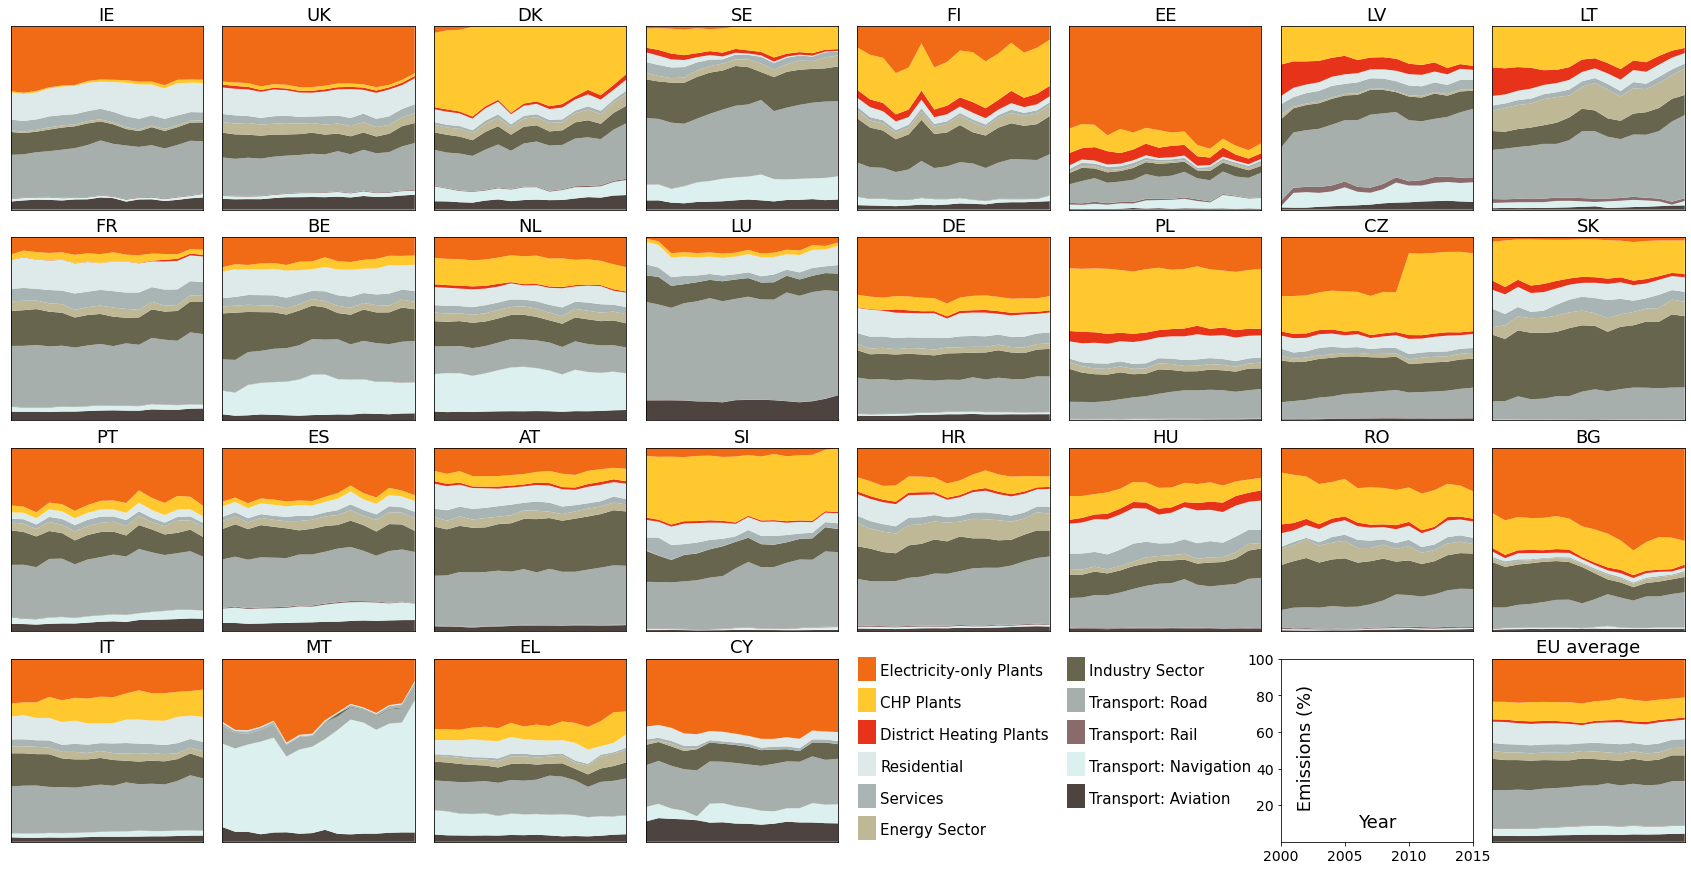

In [42]:
## Plot normalized graph
fig = plt.figure(figsize=(30, 15))
gs1 = gridspec.GridSpec(4, 8, wspace=0.1, hspace=0.15)
ax0 = plt.subplot(gs1[3,6])
ax0.set_xlim(2000,2015)
ax0.set_ylim(0,1)
ax0.set_xlabel('Year', fontsize=18, labelpad=-50)
ax0.set_xticks([2000, 2005, 2010, 2015])
ax0.set_xticklabels([2000, 2005, 2010, 2015], fontdict={'fontsize':14})
ax0.set_ylabel(' Emissions (%)', fontsize=18, labelpad=-68)
ax0.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax0.set_yticklabels([20, 40, 60, 80, 100], fontdict={'fontsize':14})

for i, country in enumerate(country_ordering):
    if i<28:
        ax1 = plt.subplot(gs1[i//8, i-(i//8)*8])
        ax1.set_title(country, fontsize=18)
    else:
        ax1 = plt.subplot(gs1[3,7])
        ax1.set_title('EU average', fontsize=18)
        
    norm = df.loc[country].sum(axis=0)
    ax1.stackplot(np.arange(2000, 2016), 
              df.loc[country].iloc[[9,10,8,7,4,3,6,5,2,1,0]] / norm, 
              colors=colors, 
              linewidth=0,
              labels=np.array(emission_keys_plot)[[9,10,8,7,4,3,6,5,2,1,0]])       
        
    ax1.set_xlim(2000, 2015)
    ax1.set_ylim(0, 1)
    ax1.set_yticks([])
    ax1.set_xticks([])
    if i == 28:
        handles, labels = ax1.get_legend_handles_labels()
        leg = ax1.legend(handles[::-1], labels[::-1], loc=(-3.33, -0.01), ncol=2, columnspacing=1.22, # prop={'size': 18},
                   fontsize=15, handlelength=1.2, frameon=False, 
                   labelspacing=1.12, handletextpad=0.3)
        for patch in leg.get_patches():
            patch.set_height(24.0)
            patch.set_y(-5)

fig.savefig(base_dir+'results/validation_secondary_data_emission_evolution.png')

In [43]:
## Load emission data into dataframe
df2 = pd.DataFrame()

for i, country in enumerate(countries + ['EU28']):
    path = '{}JRC-IDEES-2015_All_xlsx_EU28/JRC-IDEES-2015_EmissionsComparison_UNFCCC.xlsx'
    data_fec = pd.read_excel(path.format(jrc_idees_base_dir), sheet_name=country, index_col=0, header=0, squeeze=True)
    # Rename two wrongly names indexes:
    data_fec.rename(index={'1.A.1.a.  Public electricity and heat production':'1.A.1.a - Public Electricity and Heat Production'}, inplace=True)
    # Only pick out relevant indexes:
    tmp = data_fec.loc[search_index_2, years]
    # Also remove the index names:
    tmp.index.name = None    
    # Add country name to index:
    new_idx = add_index_level(tmp.index, country)
    tmp.set_index(new_idx, inplace=True)
    df2 = df2.append(tmp)

In [44]:
df2.head()

2000  \
AT Total UNFCCC emissions including international ...  68041.189040   
   1.A.1.a - Public Electricity and Heat Production     9695.287070   
   1.D.1.b - International Navigation                     72.393760   
   1.D.3 - CO2 emissions from biomass                  12758.147880   
   Total emissions (JRC-IDEES)                         71921.202505   

                                                               2001  \
AT Total UNFCCC emissions including international ...  72107.997990   
   1.A.1.a - Public Electricity and Heat Production    11291.816390   
   1.D.1.b - International Navigation                     76.511110   
   1.D.3 - CO2 emissions from biomass                  13938.613820   
   Total emissions (JRC-IDEES)                         75927.291805   

                                                               2002  \
AT Total UNFCCC emissions including international ...  73739.693750   
   1.A.1.a - Public Electricity and Heat Production    10585.476170   
   1.D.1.b - International Navigation                     86.063980   
   1.D.3 - CO2 emissions from biomass                  12902.533480   
   Total emissions (JRC-IDEES)                         77985.207222   

                                                               2003  \
AT Total UNFCCC emissions including international ...  79314.137920   
   1.A.1.a - Public Electricity and Heat Production    13102.168790   
   1.D.1.b - International Navigation                     68.618650   
   1.D.3 - CO2 emissions from biomass                  13355.767840   
   Total emissions (JRC-IDEES)                         82922.927779   

                                                               2004  \
AT Total UNFCCC emissions including international ...  79889.571330   
   1.A.1.a - Public Electricity and Heat Production    12804.988680   
   1.D.1.b - International Navigation                     81.926310   
   1.D.3 - CO2 emissions from biomass                  13478.803010   
   Total emissions (JRC-IDEES)                         84615.860763   

                                                               2005  \
AT Total UNFCCC emissions including international ...  81329.088360   
   1.A.1.a - Public Electricity and Heat Production    12934.950070   
   1.D.1.b - International Navigation                     80.365640   
   1.D.3 - CO2 emissions from biomass                  15790.273350   
   Total emissions (JRC-IDEES)                         85556.042157   

                                                               2006  \
AT Total UNFCCC emissions including international ...  78732.425350   
   1.A.1.a - Public Electricity and Heat Production    11890.463000   
   1.D.1.b - International Navigation                     70.330020   
   1.D.3 - CO2 emissions from biomass                  17046.929480   
   Total emissions (JRC-IDEES)                         83570.255957   

                                                               2007  \
AT Total UNFCCC emissions including international ...  76204.080390   
   1.A.1.a - Public Electricity and Heat Production    10566.265640   
   1.D.1.b - International Navigation                     75.440980   
   1.D.3 - CO2 emissions from biomass                  18673.494060   
   Total emissions (JRC-IDEES)                         81645.612726   

                                                               2008  \
AT Total UNFCCC emissions including international ...  75987.156970   
   1.A.1.a - Public Electricity and Heat Production    10474.643560   
   1.D.1.b - International Navigation                     69.673690   
   1.D.3 - CO2 emissions from biomass                  19945.082280   
   Total emissions (JRC-IDEES)                         81803.418617   

                                                               2009  \
AT Total UNFCCC emissions including international ...  69538.926370   
   1.A.1.a - Public Electricity and Heat Production     9421.884020   
   1.D.

In [45]:
## Split IDEES "Conventional Thermal Power Stations" into "Electricity-only Plants" & "CHP Plants"
# The sheet "EmissionsComparison" does not split "Main Activity Producer Conventional Power Stations" into it's two contributions.
# For this we need the sheet "EmissionBalance_EU28" where we have "Electricity-only Plants" and "CHP Plants". 
# These do on the other hand include autoproducers and we need the first sheet to subtract this contribution. 
search_index_3 = ['Electricity-only Plants', 'CHP Plants']  # 'District Heating Plants' is the same as already parsed and hence ignored.

## Load emission data into dataframe. Here, only for EU28, not for the individual countries!
path = '{}JRC-IDEES-2015_All_xlsx_EU28/JRC-IDEES-2015_EmissionBalance_EU28.xlsx'
data_fec = pd.read_excel(path.format(jrc_idees_base_dir), sheet_name='index', index_col=0, header=0, squeeze=True)
# Only pick out relevant indexes.
df3 = data_fec.loc[search_index_3, years]
# Also remove the index names.
df3.index.name = None

## Subtract the autoproducer contribution from these assuming that the share is proportional.
autopr = df2.loc['EU28','Autoproducer Conventional Power Stations'].to_frame().transpose().droplevel(0)
f = 1 + (1 - autopr) / (df3.iloc[0] + df3.iloc[1])
f.rename(index={f.index[0] : '0'}, inplace=True)
df3 = df3 * f.values

In [46]:
df3

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Electricity-only Plants,868267.432239,887506.363917,904676.040762,909040.315179,899193.055899,899265.159851,906607.583339,917201.995875,859738.104056,779281.437481,752620.373596,761727.861959,783857.252250,735809.064685,680195.804903,660983.529882
CHP Plants,350794.718940,364974.850248,370654.883149,401692.919094,395193.184268,389748.585815,406669.050303,401606.462694,394970.989869,371711.657184,419144.468238,395165.102475,381481.098511,362810.018797,340547.410448,340528.263949


In [47]:
## Split CHP contribution into heat and electricity emissions
search_index_4 = ['Transformation input - Eurostat structure (ktoe)', 
                  'Total gross heat production (GWh)', 
                  'Total gross electricity production (GWh)', 
                  'Total own use (GWh)']

## Load emission data into dataframe. Here, only for EU28, not for the individual countries!
path = '{}JRC-IDEES-2015_All_xlsx_EU28/JRC-IDEES-2015_PowerGen_EU28.xlsx'
data_fec = pd.read_excel(path.format(jrc_idees_base_dir), sheet_name='Thermal_CHP', index_col=0, header=0, squeeze=True)

# Only pick out relevant indexes.
data_fec.columns = data_fec.columns.map(int)
df4 = data_fec.loc[search_index_4, years]
# Also remove the index names.
df4.index.name = None
# Unit conversion.
df4 = df4.append((df4.loc['Transformation input - Eurostat structure (ktoe)'] * 11.63000).to_frame().transpose().rename(index={
                                                                        'Transformation input - Eurostat structure (ktoe)':'Transformation input (GWh)'}))

In [48]:
df4

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Transformation input - Eurostat structure (ktoe),1.210993e+05,1.256195e+05,1.288323e+05,1.417640e+05,1.441073e+05,1.455573e+05,1.527050e+05,1.523453e+05,1.511229e+05,1.443670e+05,1.631284e+05,1.554353e+05,1.528041e+05,1.464442e+05,1.391791e+05,1.411928e+05
Total gross heat production (GWh),4.092735e+05,4.400056e+05,4.335086e+05,4.667105e+05,5.252515e+05,5.245425e+05,5.312775e+05,5.114260e+05,5.093787e+05,4.928186e+05,5.453685e+05,5.109788e+05,4.979264e+05,4.981618e+05,4.591080e+05,4.677314e+05
Total gross electricity production (GWh),4.674241e+05,4.804777e+05,4.972427e+05,5.412521e+05,5.602978e+05,5.788350e+05,6.119361e+05,6.150726e+05,6.123698e+05,5.921916e+05,6.683784e+05,6.362191e+05,6.267170e+05,5.988935e+05,5.648043e+05,5.816010e+05
Total own use (GWh),3.241263e+04,3.290978e+04,3.405849e+04,3.625121e+04,3.667901e+04,3.737287e+04,3.936965e+04,3.900589e+04,3.857612e+04,3.928672e+04,4.427053e+04,4.348007e+04,4.392018e+04,4.255238e+04,4.110232e+04,4.204802e+04
Transformation input (GWh),1.408385e+06,1.460955e+06,1.498320e+06,1.648715e+06,1.675968e+06,1.692832e+06,1.775960e+06,1.771776e+06,1.757559e+06,1.678988e+06,1.897183e+06,1.807712e+06,1.777111e+06,1.703146e+06,1.618653e+06,1.642072e+06


In [49]:
# Calculate the fraction of the emissions that are due to electricity production in CHP.
tmp1 = df4.loc['Transformation input (GWh)']
tmp2 = df4.loc['Total gross heat production (GWh)']
tmp3 = df4.loc['Total own use (GWh)']
#frac = (tmp1 - tmp3/2 - tmp2 / 0.9) / (tmp1)
frac = (tmp1 - tmp2 / 0.9) / (tmp1)

# Attribute emissions.
emissions_electricity_from_CHP_plants = df3.loc['CHP Plants'] * frac
emissions_heat_from_CHP_plants = df3.loc['CHP Plants'] * (1 - frac)

In [50]:
## Read data files created in part 1
elec_emission = pd.read_csv(base_dir+'results/elec_emissions.csv', index_col=(0,1)).squeeze()
elec_emission_incl_autoprod = pd.read_csv(base_dir+'results/elec_emission_incl_autoprod.csv', index_col=(0,1)).squeeze()

countries_eea = countries.copy()
countries_eea.remove('UK')
countries_eea.append('GB')
countries_eea.remove('EL')
countries_eea.append('GR')

elec_emissions = elec_emission[countries_eea].sum(level=1).to_frame().transpose().rename({'electricity-only emissions':'emissions'}) / 1e3
elec_emission_incl_autoprod = elec_emission_incl_autoprod[countries_eea].sum(level=1).to_frame().transpose().rename({'electricity-only emissions':'emissions'}) / 1e3

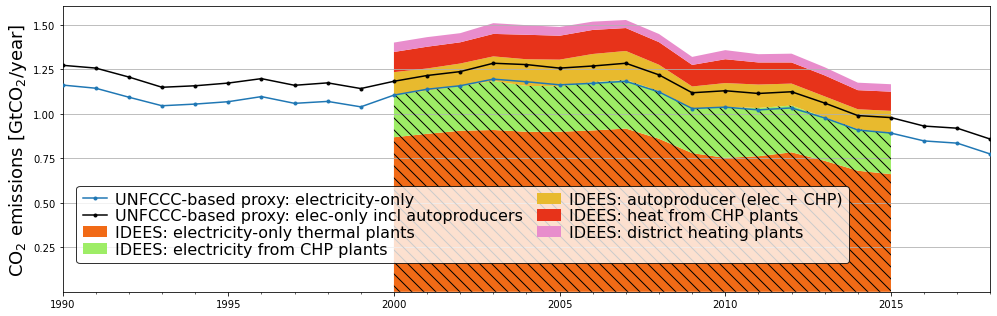

In [51]:
## Plot comparison between the datasets
fig = plt.figure(figsize=(14, 4.5))
ax1 = plt.subplot()

# Computed proxy part
ax1.plot(elec_emissions.columns, elec_emissions.values[0], '.-', zorder=10, label='UNFCCC-based proxy: electricity-only')
ax1.plot(elec_emission_incl_autoprod.columns, elec_emission_incl_autoprod.values[0], '.-k', zorder=10, label='UNFCCC-based proxy: elec-only incl autoproducers')

# IDEES parts
ax1.stackplot(np.arange(2000,2016), [#df2.loc['EU28','Main Activity Producer Conventional Power Stations'] / 1e6,
                                     df3.loc['Electricity-only Plants'] / 1e6,
                                     emissions_electricity_from_CHP_plants / 1e6,
                                     df2.loc['EU28','Autoproducer Conventional Power Stations'] / 1e6,
                                     emissions_heat_from_CHP_plants / 1e6,
                                     df2.loc['EU28','District Heating Plants'] / 1e6],
    colors = ['#F16A16', '#9eed66', '#e8ba2e', '#E7331A', '#e88dcc'], linewidth = 0,
    labels = ['IDEES: electricity-only thermal plants',
              'IDEES: electricity from CHP plants',
              'IDEES: autoproducer (elec + CHP)',
              'IDEES: heat from CHP plants',
              'IDEES: district heating plants'], zorder=0);
a = ax1.stackplot(np.arange(2000,2016), (df3.loc['Electricity-only Plants'] + emissions_electricity_from_CHP_plants) / 1e6, colors=['none'], edgecolor='k', linewidth=0, zorder=2)
a[0].set_hatch("\\\\")

ax1.set_yticks(np.arange(0.25, 1.7, 0.25))
ax1.set_xlim([1990, 2018])
ax1.tick_params(axis='both', which='minor', zorder=40) #, length=8, color='k', width=1, direction='in')
plt.grid(axis='y')
ax1.set_ylabel('CO$_2$ emissions [GtCO$_{2}$/year]', fontsize=18)
ax1.xaxis.set_minor_locator(AutoMinorLocator())

ax1.plot(np.NaN, np.NaN, '-', color='none', label=' ')
handles, labels = ax1.get_legend_handles_labels()
order = [0,1, 3,4,5,6,7]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], ncol=2, columnspacing=0.9, handlelength=1.5,
           loc=(0.015, 0.1),  fontsize=16, labelspacing=0.1, handletextpad=0.5, frameon=True, edgecolor='black', )
plt.tight_layout();
fig.savefig(base_dir+'results/validation_comparison.png')